# Training a DQN Agent for Breakout-v5
This notebook provides a clean and modular training pipeline for Deep Q-Learning using **Breakout-v5**.


##  Step 1: Install and Import Dependencies



In [1]:
# Install all required packages
!pip install -q gymnasium ale-py opencv-python numpy matplotlib tensorflow

# Install AutoROM and download ROMs
!pip install -q autorom
!AutoROM --accept-license

# Import ale_py to automatically register ROMs
import ale_py

# Import gymnasium to register ALE environments
import gymnasium as gym

# Verify installation
ale_envs = [env_id for env_id in gym.envs.registry.keys() if 'ALE' in env_id]
print(f"All packages installed successfully!")
print(f"Found {len(ale_envs)} ALE/Atari environments")

if len(ale_envs) == 0:
    print("\n ROMs not found. Please RESTART THE RUNTIME now!")
    print("After restart, skip this cell and run the import cell directly.")
else:
    print("You're ready to go! Continue to the next cells.")

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
All packages installed successfully!
Found 104 ALE/Atari environments
You're ready to go! Continue to the next cells.


## Installing Required Libraries

- **gymnasium**: The RL environment framework
- **ale-py**: Arcade Learning Environment for Atari games
- **AutoROM**: Downloads Atari game ROM files
- **opencv-python**: Image processing
- **numpy**: Numerical computing
- **matplotlib**: Visualization
- **tensorflow**: Deep learning framework



In [5]:
import gymnasium as gym
import numpy as np
import cv2
import random
from collections import deque
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [2]:
# Verify that ALE environments are available
import gymnasium as gym

# Check if ALE environments are registered
ale_envs = [env_id for env_id in gym.envs.registry.keys() if 'ALE' in env_id]

if len(ale_envs) > 0:
    print(f" SUCCESS! Found {len(ale_envs)} ALE/Atari environments")
    print(f" Breakout is available: {'ALE/Breakout-v5' in ale_envs}")
else:
    print(" ERROR: No ALE environments found!")
    print("  Please restart the runtime and try again.")

 SUCCESS! Found 104 ALE/Atari environments
 Breakout is available: True


###  Importing the Libraries

Now we import the libraries we just installed:
- **gym**: To create and interact with the Breakout game
- **numpy**: For handling arrays and numbers
- **cv2**: OpenCV for image processing
- **random**: For random action selection during exploration
- **deque**: A special list that automatically removes old items
- **tensorflow/keras**: For building and training neural networks
- **matplotlib**: For displaying game frames and graphs

##  Step 2: Create and Wrap the Breakout Environment

**What happens here:**
We create the game environment where our agent will learn to play. The environment is like a video game console - it shows us what's on screen, accepts our button presses (actions), and tells us our score (rewards).

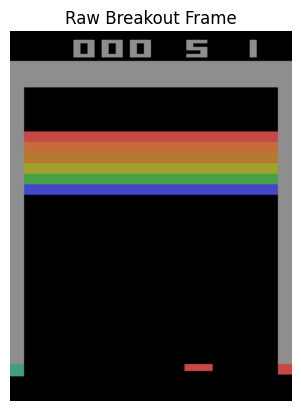

In [6]:
def make_env():
    env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
    return env

env = make_env()
obs, info = env.reset()
plt.imshow(obs)
plt.title("Raw Breakout Frame")
plt.axis("off")
plt.show()

### 🎮 Creating the Breakout Game Environment

This code does three things:
1. **Creates** the Breakout-v5 game environment
2. **Resets** the environment to get the first game screen
3. **Displays** the raw game frame so you can see what the agent will see

The environment gives us:
- **obs**: The game screen (an image with pixels)
- **info**: Extra information about the game state

## Step 3: Fixed Architectures

**What happens here:**
We define two neural network architectures that the agent can use to learn. Think of these as the "brain" of the agent - they take in game images and decide which action to take.

In [7]:
def create_cnn_model(num_actions):
    inputs = layers.Input(shape=(84, 84, 4))

    x = layers.Conv2D(32, 8, strides=4, activation='relu')(inputs)
    x = layers.Conv2D(64, 4, strides=2, activation='relu')(x)
    x = layers.Conv2D(64, 3, strides=1, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(num_actions)(x)

    return keras.Model(inputs, outputs)

def create_mlp_model(num_actions):
    inputs = layers.Input(shape=(84,84,4))

    x = layers.Flatten()(inputs)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    outputs = layers.Dense(num_actions)(x)

    return keras.Model(inputs, outputs)

def select_architecture(arch_name, num_actions):
    if arch_name == "cnn":
        return create_cnn_model(num_actions)
    elif arch_name == "mlp":
        return create_mlp_model(num_actions)
    else:
        raise ValueError("Invalid architecture selection")


###  Neural Network Architectures

**Two architectures are available:**

1. **CNN (Convolutional Neural Network)** - Recommended for image-based games
   - Uses 3 convolutional layers to detect visual patterns (edges, shapes, objects)
   - Has 1 fully connected layer with 512 neurons
   - Best for games like Breakout where the agent sees pixels
   
2. **MLP (Multi-Layer Perceptron)** - Simple fully connected network
   - Uses 2 hidden layers with 256 neurons each
   - Simpler but less effective for images
   - Can be used for comparison

##  Step 4: Hyperparameter Block


In [8]:
HYPERPARAMS= {
    "architecture": "mlp",
    "learning_rate": 0.0004,
    "gamma": 0.95,
    "epsilon_start": 1.0,
    "epsilon_end": 0.08,
    "epsilon_decay_frames": 40000,
    "batch_size": 12,
    "buffer_size": 6000,
    "train_start": 800,
    "target_update_freq": 1200,
    "max_episodes": 200
}

### 🎯 Configuring Your Hyperparameters

**What each hyperparameter means:**

- **architecture**: Choose "cnn" or "mlp" - which brain design to use
- **learning_rate**: How fast the agent learns (0.00025 = slow but stable)
- **gamma**: How much to value future rewards (0.99 = very forward-thinking)
- **epsilon_start**: Starting exploration rate (1.0 = 100% random actions at first)
- **epsilon_end**: Final exploration rate (0.1 = always keep 10% randomness)
- **epsilon_decay_frames**: How many steps to reduce exploration gradually
- **batch_size**: How many experiences to learn from at once
- **buffer_size**: How many past experiences to remember
- **train_start**: Wait this many steps before training begins (collect data first)
- **target_update_freq**: How often to update the stable target network
- **max_episodes**: How many complete games to play during training

**Try different values and compare results with your team!**

## Step 5: Observation Preprocessing

In [9]:
def preprocess(frame):
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame_resized = cv2.resize(frame_gray, (84,84))
    return frame_resized / 255.0


### Image Processing Function

This function does three things to each game frame:
1. **Convert to grayscale**: Remove color information (we only need shapes, not colors)
2. **Resize to 84x84**: Make the image smaller for faster processing
3. **Normalize**: Scale pixel values from 0-255 to 0-1 (helps the neural network learn better)

Think of it like taking a photo and making it smaller and black-and-white to save space!

##  Step 6: Replay Buffer

In [10]:
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, experience):
        state, action, reward, next_state, done = experience

        # Convert to uint8 (VERY IMPORTANT)
        state = state.astype(np.uint8)
        next_state = next_state.astype(np.uint8)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in indices])

        # Convert back to float32 for training and normalize
        states = np.array(states, dtype=np.float32) / 255.0
        next_states = np.array(next_states, dtype=np.float32) / 255.0

        return (
            states,
            np.array(actions),
            np.array(rewards),
            next_states,
            np.array(dones)
        )

 Replay Buffer Class

This class creates a storage system for experiences:
- **add()**: Saves a new experience (state, action, reward, next_state, done)
- **sample()**: Randomly picks a batch of experiences to learn from

**Why use a replay buffer?**
- Breaks correlation between consecutive experiences
- Allows the agent to learn from past successes and failures
- Makes training more stable and efficient
- Reuses experiences multiple times

## 🤖 Step 7: Build the Selected Model

In [11]:
num_actions = env.action_space.n
model = select_architecture(HYPERPARAMS["architecture"], num_actions)
target_model = select_architecture(HYPERPARAMS["architecture"], num_actions)
target_model.set_weights(model.get_weights())

optimizer = keras.optimizers.Adam(learning_rate=HYPERPARAMS["learning_rate"])
loss_fn = keras.losses.Huber()


### 🔧 Creating the Q-Networks

This code sets up:
1. **Main Model**: The neural network that learns and gets updated frequently
2. **Target Model**: A stable copy used for calculating target Q-values
3. **Optimizer**: Adam optimizer that adjusts the network weights during training
4. **Loss Function**: Huber loss that measures how wrong the predictions are

**Why two models?**
Using a target model that updates slowly prevents the training from becoming unstable. It's like having a steady reference point while learning.

In [12]:
def evaluate_agent(model, env, num_eval_episodes=10, epsilon=0.05):
    """
    Evaluate agent performance with low exploration

    Args:
        model: Trained Q-network
        env: Gym environment
        num_eval_episodes: Number of episodes to average
        epsilon: Low exploration rate for evaluation

    Returns:
        Average reward over evaluation episodes
    """
    eval_rewards = []

    for _ in range(num_eval_episodes):
        obs, _ = env.reset()
        state = preprocess(obs)
        state_stack = np.stack([state]*4, axis=-1)

        episode_reward = 0
        done = False

        while not done:
            # Mostly exploit, minimal exploration
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_vals = model(np.expand_dims(state_stack, axis=0))
                action = np.argmax(q_vals[0].numpy())

            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            next_state = preprocess(next_obs)
            state_stack = np.append(state_stack[:,:,1:],
                                   np.expand_dims(next_state, axis=-1),
                                   axis=-1)
            episode_reward += reward

        eval_rewards.append(episode_reward)

    return np.mean(eval_rewards)

## Step 8: Training Loop

In [13]:
import gc
import psutil
def train_dqn_agent(env, model, target_model, optimizer, loss_fn,
                   hyperparams, model_name="breakout_model"):
    """
    Train a DQN agent with evaluation-based model saving
    """
    buffer = ReplayBuffer(hyperparams["buffer_size"])
    epsilon = hyperparams["epsilon_start"]
    frame_count = 0

    # Tracking
    episode_rewards = []
    episode_losses = []
    episode_epsilons = []
    episode_steps = []

    # IMPROVED: Evaluation-based best model tracking
    best_eval_reward = -float('inf')
    best_model_weights = None
    best_episode = 0
    eval_history = []
    eval_episodes_list = []

    # Evaluation settings
    EVAL_FREQUENCY = 50
    NUM_EVAL_EPISODES = 5  # Reduced for faster evaluation

    num_actions = env.action_space.n

    print(f"Starting training for {model_name}...")
    print(f"Total episodes: {hyperparams['max_episodes']}")
    print(f"Evaluation every {EVAL_FREQUENCY} episodes")
    print(f"Training will start after {hyperparams['train_start']} frames\n")

    for episode in range(hyperparams["max_episodes"]):
        obs, _ = env.reset()
        state = preprocess(obs)
        state_stack = np.stack([state]*4, axis=-1)

        episode_reward = 0
        episode_loss_sum = 0
        loss_count = 0
        steps = 0
        done = False

        # Training episode
        while not done:
            frame_count += 1
            steps += 1

            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_vals = model(np.expand_dims(state_stack, axis=0))
                action = np.argmax(q_vals[0].numpy())

            frame_skip = 2
            total_reward = 0
            for _ in range(frame_skip):
                next_obs, reward, terminated, truncated, _ = env.step(action)
                total_reward += reward
                if terminated or truncated:
                    done = True
                    break

            next_state = preprocess(next_obs)
            next_state_stack = np.append(state_stack[:,:,1:],
                                        np.expand_dims(next_state, axis=-1),
                                        axis=-1)

            buffer.add((state_stack, action, total_reward, next_state_stack, done))
            state_stack = next_state_stack
            episode_reward += total_reward

            # Training step
            if frame_count > hyperparams["train_start"]:
                states, actions, rewards, next_states, dones = buffer.sample(
                    hyperparams["batch_size"])

                next_q = target_model(next_states)
                max_next_q = np.max(next_q.numpy(), axis=1)
                target_q = rewards + (1 - dones) * hyperparams["gamma"] * max_next_q

                masks = tf.one_hot(actions, num_actions)

                with tf.GradientTape() as tape:
                    q_values = model(states)
                    q_action = tf.reduce_sum(q_values * masks, axis=1)
                    loss = loss_fn(target_q, q_action)

                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

                episode_loss_sum += loss.numpy()
                loss_count += 1

            # Epsilon decay
            epsilon = max(hyperparams["epsilon_end"],
                         hyperparams["epsilon_start"] -
                         (hyperparams["epsilon_start"] - hyperparams["epsilon_end"]) *
                         (frame_count / hyperparams["epsilon_decay_frames"]))

            # Target network update
            if frame_count % hyperparams["target_update_freq"] == 0:
                target_model.set_weights(model.get_weights())

        # Store metrics
        episode_rewards.append(episode_reward)
        episode_epsilons.append(epsilon)
        episode_steps.append(steps)
        avg_loss = episode_loss_sum / loss_count if loss_count > 0 else 0
        episode_losses.append(avg_loss)

        # ========================================
        # IMPROVED: EVALUATION-BASED MODEL SAVING
        # ========================================
        if (episode + 1) % EVAL_FREQUENCY == 0:
            print(f"Evaluating agent at episode {episode+1}...")

            eval_reward = evaluate_agent(model, env,
                                        num_eval_episodes=NUM_EVAL_EPISODES,
                                        epsilon=0.05)

            eval_history.append(eval_reward)
            eval_episodes_list.append(episode + 1)

            print(f"Evaluation Reward: {eval_reward:.2f}")

            # Save if this is the best evaluation performance
            if eval_reward > best_eval_reward:
                best_eval_reward = eval_reward
                best_model_weights = model.get_weights()
                best_episode = episode

                # Save immediately
                model.save(f"{model_name}_best.keras")
                print(f"NEW BEST MODEL! Eval Reward: {eval_reward:.2f} - SAVED!")
                print(f"   (Previous best: {best_eval_reward:.2f})")
            else:
                print(f"   (Current best: {best_eval_reward:.2f} at episode {best_episode+1})")
            print()

        # Memory management
        if episode % 50 == 0:
            gc.collect()
            memory_usage = psutil.virtual_memory().percent
            if memory_usage > 85:
                tf.keras.backend.clear_session()
                print(f"Memory cleaning at {memory_usage}%")

        # Progress printing
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            print(f"Episode {episode+1}/{hyperparams['max_episodes']} | "
                  f"Reward: {episode_reward:.1f} | "
                  f"Avg(10): {avg_reward:.1f} | "
                  f"Epsilon: {epsilon:.3f} | "
                  f"Steps: {steps} | "
                  f"Loss: {avg_loss:.4f}")

    print("\nTraining completed!")

    # Final model saving
    if best_model_weights is not None:
        model.set_weights(best_model_weights)
        model.save(f"{model_name}_best_final.keras")
        print(f"BEST model saved from episode {best_episode+1}")
        print(f"Best evaluation reward: {best_eval_reward:.2f}")

    # Save final model for comparison
    model.save(f"{model_name}_final.keras")
    print(f"Final model also saved")

    # Cleanup
    gc.collect()
    tf.keras.backend.clear_session()

    return {
        'episode_rewards': episode_rewards,
        'episode_losses': episode_losses,
        'episode_epsilons': episode_epsilons,
        'episode_steps': episode_steps,
        'eval_history': eval_history,
        'eval_episodes': eval_episodes_list,
        'best_episode': best_episode,
        'best_eval_reward': best_eval_reward
    }

In [14]:
training_history1 = train_dqn_agent(
    env=env,
    model=model,
    target_model=target_model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    hyperparams=HYPERPARAMS,
    model_name="mlp_model_fast"
)

Starting training for mlp_model_fast...
Total episodes: 200
Evaluation every 50 episodes
Training will start after 800 frames

Episode 10/200 | Reward: 1.0 | Avg(10): 2.2 | Epsilon: 0.973 | Steps: 87 | Loss: 0.0084
Episode 20/200 | Reward: 3.0 | Avg(10): 2.6 | Epsilon: 0.943 | Steps: 131 | Loss: 0.0089
Episode 30/200 | Reward: 0.0 | Avg(10): 1.6 | Epsilon: 0.919 | Steps: 74 | Loss: 0.0061
Episode 40/200 | Reward: 3.0 | Avg(10): 1.7 | Epsilon: 0.894 | Steps: 127 | Loss: 0.0087
Evaluating agent at episode 50...
Evaluation Reward: 1.40
NEW BEST MODEL! Eval Reward: 1.40 - SAVED!
   (Previous best: 1.40)

Episode 50/200 | Reward: 1.0 | Avg(10): 0.9 | Epsilon: 0.873 | Steps: 87 | Loss: 0.0071
Episode 60/200 | Reward: 1.0 | Avg(10): 2.1 | Epsilon: 0.845 | Steps: 79 | Loss: 0.0099
Episode 70/200 | Reward: 2.0 | Avg(10): 1.9 | Epsilon: 0.817 | Steps: 108 | Loss: 0.0073
Episode 80/200 | Reward: 2.0 | Avg(10): 1.8 | Epsilon: 0.790 | Steps: 110 | Loss: 0.0068
Episode 90/200 | Reward: 0.0 | Avg(10)

### 🎮 The Main Training Process

**What this code does step-by-step:**

1. **Initialize replay buffer and exploration rate (epsilon)**
2. **For each episode (game):**
   - Reset the environment and get starting state
   - Stack 4 frames together (to detect motion)
   
3. **For each step in the episode:**
   - **Choose action**: Either random (explore) or best action (exploit)
   - **Take action**: Execute it in the game
   - **Store experience**: Save (state, action, reward, next_state) in buffer
   - **Learn from experience**: Sample random batch from buffer and train
   - **Update networks**: Adjust weights using gradient descent
   - **Decay epsilon**: Gradually reduce exploration over time
   - **Update target network**: Copy main model weights periodically

4. **Print progress**: Show reward for each episode

**Key concepts:**
- **Epsilon-greedy**: Balance between exploring (random) and exploiting (learned)
- **Experience replay**: Learn from random samples, not just recent experiences
- **Target network**: Stable reference prevents training instability
- **Frame stacking**: 4 frames together help detect ball movement